# EDM Genre: Dowloading Tracks and Audio Features from Spotify

In the following six sections, this notebook will describe the steps for accessing two Spotify API endpoints (Get a Playlist's Tracks and Get Audio Features), performing EDA on audio features, and downloading the 30 second mp3 files directly to your local drive.

- Step 1 = [Spotify Client Credentials](#section1)
- Step 2 = [Spotify API Request: Get a Playlist's Tracks](#section2)
- Step 3 = [Spotify API Request: Get Audio Features](#section3)
- Step 4 = [EDA of Audio Features](#section4)
- Step 5 = [Merge Dataframes](#section5)
- Step 6 = [Download EDM files to Local Drive](#section6)


**Helpful resources I used include:**
<br>Shout-out to this blogpost and github link from Tomi Gelo which helped me bypass the track request limits and use the list of track_ids to download audio features!
 - https://github.com/tgel0/spotify-data/blob/master/notebooks/SpotifyDataRetrieval.ipynb
 - https://tgel0.github.io/blog/spotify-data-project-part-1-from-data-retrieval-to-first-insights/

In [23]:
#load imports
import pandas as pd
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import config

%matplotlib inline

***Preliminary steps to complete before making requests to Spotify API:***
1. If necessary, sign-up for a free Spotify account. Obtain personal user ID from profile 
1. Create an application through Spotify's web developer page https://developer.spotify.com/dashboard/login
2. In the dashboard, create a personal client id and client secret
3. In terminal, pip install Spotipy (a python wrapper)

 <a id='section1'></a>
## Step 1. Obtaining Authorization: Spotify Client Credentials


- Of Spotify's three different options for obtaining authorization, we will use the Client Credentials Flow. This option is sufficient since we only want to access public data rather than our own private user data. Different authorization methods may be required for the type of data retrieved (public or private) as well as the intended data application (personal vs. public use). For more information on authorization options, see https://developer.spotify.com/documentation/general/guides/authorization-guide/

- In order to more easily access Spotify's API using python, we will use **Spotipy**, a wrapper library that will authorize our credentials with Spotify and make and receive requests. To correspond to Spotify's different authorization flows, the Spotipy library also includes different authorization modules based on the type of data you want to collect. We will be using Spotipy's **Client Credentials Flow** for simplicity; if we wanted access to our private data, we would need to use an Authorization Code Flow.    https://spotipy.readthedocs.io/en/latest/


In [24]:
# use Spotipy library to authorize my credentials, using the Client Credentials Flow 
client_credentials_manager = SpotifyClientCredentials(client_id=config.CLIENT_ID, client_secret=config.CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

<a id='section2'></a>
## Step 2: Spotify API Request: Get a Playlist's Tracks

We want to get the full list of track IDs from a playlist of songs, as well as the mp3 link and other low level track details. To do this, we will use the "Get a Playlist's Tracks" endpoint from Spotify's API.
<br> https://developer.spotify.com/documentation/web-api/reference/playlists/get-playlists-tracks/
- To query this API we must provide the unique playlist ID (found on the playlist's webpage) as well as our own valid access token. In order to bypass the return limit of 100 tracks per playlist, we will set up a for loop that includes an offset.
- Different Spotipy methods perform different requests (as they are accessing different Spotify endpoints) and essentially return a different Spotify object. While we want to access the "Get a Playlist's Tracks" endpoint, we will use **Spotipy's method user_playlist_tracks** to do this. 
- This request will return an array of track objects (information such as track/artist name, track duration, links to spotify track page, etc.) in a JSON format which will be used to parse out only the necessary information. 
- The public playlist I decided to use came from a general google search for "spotify EDM playlist". It's titled "The Best EDM Playlist on the Planet" by Matt Hoppe, and it should contain 1688 songs. https://open.spotify.com/playlist/6pPyTrqNK0nNsCmfmZWY6l


**Step 2.1: Observe what information (or track objects) are provided from the second song in our playlist**

In [18]:
#Start track download. Params = user id, playlist id
results = sp.user_playlist_tracks(config.USER_ID, '6pPyTrqNK0nNsCmfmZWY6l') 

for item in results['items'][1:2]: #print only the first track
    print(item['track'])

{'disc_number': 1, 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO', 'SA', 'SE', 'SG', 'SK', 'SV', 'TH', 'TN', 'TR', 'TW', 'US', 'UY', 'VN', 'ZA'], 'type': 'track', 'href': 'https://api.spotify.com/v1/tracks/4uXYtzIjJ2vJG8JrfWwkA1', 'album': {'name': 'Afterglow', 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA'

This is the JSON object returned for a single track and contains way more information than we need, such as the countries the track is available to stream. 

**Step 2.2: Observe the artist and track name for the first 5 songs**  

In [19]:
results = sp.user_playlist_tracks(config.USER_ID, '6pPyTrqNK0nNsCmfmZWY6l')
for item in results['items'][:5]:
    track = item['track']
    print(track['name'] + ' - ' + track['artists'][0]['name'])

Coming Home - Seven Lions & Ricky Mears Festival Radio Mix - Seven Lions
Afterglow - Codeko
Good Grief - Don Diablo Remix - Bastille
Hey - KIIDA Remix - FÄIS
Follow The Light - ARTY


**Step 2.3: Finally, let's download all the track details for every song in the EDM playlist!**

In [5]:
# create empty lists (each will become a column in our dataframe)
track_id = []
track_name = []
mp3 = []
track_length = []
track_pop = []
album_date = []
artist_id = []
artist_name = []
None_counter = 0 #track the number of songs without a mp3 link


for j in range(0, 3000, 100): 
    #Start track download. Params = user id, playlist id;  offset to get more than 100 tracks
    results = sp.user_playlist_tracks(config.USER_ID, '6pPyTrqNK0nNsCmfmZWY6l', offset=j) 
    for i, t in enumerate(results['items']): 
        track_id.append(t['track']['id'])
        track_name.append(t['track']['name'])
        mp3.append(t['track']['preview_url'])
        if t['track']['preview_url'] == None:
            None_counter += 1     #we won't want to keep these tracks without an mp3 link     
        track_length.append(t['track']['duration_ms'])
        track_pop.append(t['track']['popularity'])
        album_date.append(t['track']['album']['release_date'])

        for a, b in enumerate(t['track']['artists']):
            if a == 0:          #only prints the FIRST artist  (a=0(1 artist);  a=1(2 artists), etc)
                                #we only want 1 artist per track so everything will fit nicely into a dataframe
                artist_id.append(b['id'])
                artist_name.append(b['name'])


#put all the new lists into a dataframe
df_tracks = pd.DataFrame({'track_id':track_id,"track_name": track_name, "mp3": mp3, "track_length": track_length, 
                         "track_pop": track_pop, "album_date": album_date, "artist_id": artist_id, 
                          "artist_name": artist_name})

print('Total number of tracks in playlist:', len(df_tracks))
print('Number of tracks without mp3 link:',None_counter)
print('Number of usable tracks:', int(len(df_tracks))-None_counter)


df_tracks.head()

Total number of tracks in playlist: 1688
Number of tracks without mp3 link: 759
Number of usable tracks: 929


,album_date,artist_id,artist_name,mp3,track_id,track_length,track_name,track_pop
0,2016-06-10,6fcTRFpz0yH79qSKfof7lp,Seven Lions,None,7JEUOWAaxawgtUoApClOkc,219186,Coming Home - Seven Lions & Ricky Mears Festiv...,28
1,2016-07-08,7FZKXzbyCoai0fEh65kZKp,Codeko,https://p.scdn.co/mp3-preview/4049f24671437021...,4uXYtzIjJ2vJG8JrfWwkA1,248437,Afterglow,29
2,2016-07-08,7EQ0qTo7fWT7DPxmxtSYEc,Bastille,None,5dSFlPDHjAuYU1apyrRgqV,239000,Good Grief - Don Diablo Remix,55
3,2016-07-08,5w6mMj1qwSILG0pcylfchp,FÄIS,None,5FbsV3XIKW9pBPbBff6htf,296135,Hey - KIIDA Remix,0
4,2016-07-08,1rSGNXhhYuWoq9BEz5DZGO,ARTY,https://p.scdn.co/mp3-preview/46d5cea122bf5b21...,6ywNLnm0a3t8Hom8AGKEhb,262501,Follow The Light,31


So out of the 1688 songs in this playlist, only 929 songs (about 55%) have an mp3 link and are usable for our analysis. 

#### Step 2.4: Explore the mp3 link
Clicking on the mp3 link will open a separate webpage that plays a 30 second clip of the song. The webpage also includes an option to download the song, which we will perform in an automated function in Step 6.


In [6]:
#print the mp3 link for the first 8 songs
for i in df_tracks.mp3[0:8]:
    print(i)

None
https://p.scdn.co/mp3-preview/4049f24671437021452603f595f180f118234999?cid=142c36ced4ff4aa68d784c0db9923467
None
None
https://p.scdn.co/mp3-preview/46d5cea122bf5b2100cd796ca379976c750487bc?cid=142c36ced4ff4aa68d784c0db9923467
https://p.scdn.co/mp3-preview/6151b6e4bf2b5e1afc34a49f341ad5a4f8ae6801?cid=142c36ced4ff4aa68d784c0db9923467
https://p.scdn.co/mp3-preview/07fce35dd4c81aa73fb094bcbad7b03795c88e7d?cid=142c36ced4ff4aa68d784c0db9923467
https://p.scdn.co/mp3-preview/374945b74c9f172ef8a7a131b668154005f8e835?cid=142c36ced4ff4aa68d784c0db9923467


#### Step 2.5: Drop songs without a mp3 link from our dataframe

In [7]:
# drop any columns that have mp3 = None, and reset index
df_tracks = df_tracks.dropna(subset = ["mp3"])
df_tracks.reset_index(drop=True, inplace=True)

print(df_tracks.shape)
df_tracks.tail()

(929, 8)


,album_date,artist_id,artist_name,mp3,track_id,track_length,track_name,track_pop
924,2018-12-07,0nTbVTXLLbBA4xCtn0cFkv,Myon,https://p.scdn.co/mp3-preview/fa0aa2f934e58db3...,1VZ3EUGMXXPtBWhaDu4bOf,236800,Hearts & Silence - Trivecta Remix,20
925,2018-12-14,6CCTvLyIHqUhY6VQizt150,Jason Ross,https://p.scdn.co/mp3-preview/41bafb99771df635...,0WSJUE47g4OEpaMzL6svD7,263977,Don't Give Up On Me (feat. Dia Frampton),45
926,2018-12-14,2ohlvFf9PBsDELdRstPtlP,Ferry Corsten,https://p.scdn.co/mp3-preview/d258c7b254b9769c...,5pO9ycBL618hEcfCOpRk3l,214153,We're Not Going Home,46
927,2018-12-14,5y3G1B8cpCTaoq0uDgjwzH,Danny Avila,https://p.scdn.co/mp3-preview/fb87efb13c19af96...,4Lb1gZyH6xGzWUNH6R8l0V,178495,End Of The Night - Danny Avila Club Mix,35
928,2019-01-04,2Npo4Cfm48M2uKlvxiXMic,Oliver Smith,https://p.scdn.co/mp3-preview/075f5e4f3864bdfc...,2uVIxV2ZXvIC9JJb0GbWZK,217558,Solina,48


Now we have the expected number, 929 songs, to use for our analysis

#### Step 2.6: EDA on any numerical columns from df_tracks dataframe

In [8]:
df_tracks.describe()

,track_length,track_pop
count,929.000000,929.000000
mean,257823.890205,29.270183
std,62705.571011,16.979551
min,140000.000000,0.000000
25%,208615.000000,17.000000
50%,240000.000000,27.000000
75%,301863.000000,39.000000
max,467272.000000,85.000000


The only numerical insights we can take from this dataframe is the length of the song in milliseconds, and a rating for song popularity between 0 to 100, which may not be informative as it's based on several different factors. 

<a id='section3'></a>
## Step 3: Spotify API Request: Get Audio Features for Several Tracks

This is a new request for a different Spotify endpoint, using the list of `track_id`s acquired from the first request. Spotify uses algorithms to extract audio and acoustic features from songs. These attributes include things like key and tempo, as well as some high-level attributes such as danceability (how suitable a track is for dancing) and valence (how "happy" a song sounds). 
- While I did not use these audio features in my network or any other modeling, I felt it important to examine how these features might be rated differently for the different genres and see what information they contained. 
- For the API documentation, see: https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/

#### Step 3.1: Download Audio Features

In [9]:
rows = []          #list to append each track features to 
batchsize = 100    #max number of track ids we're allowed to submit per query
None_counter = 0   #count if there are any songs without any audio features

for i in range(0,len(df_tracks['track_id']), batchsize):    #batchsize = offset
    batch = df_tracks['track_id'][i:i+batchsize]            #batch is now a list of all 929 track_ids
    
    feature_results = sp.audio_features(batch)              #begins querying the audio features endpoint

    for i, t in enumerate(feature_results):
        if t == None:                               #if the audio features for a song are missing, count 1        
            None_counter += 1          
        else:
            rows.append(t)  
print('Number of tracks where no audio features were available:',None_counter)
print('Number of usable tracks:', len(rows))

Number of tracks where no audio features were available: 0
Number of usable tracks: 929


#### Step 3.2: Examine columns and create a dataframe
Each song returns 18 different audio features descriptors, shown below

In [10]:
rows[1]

{'acousticness': 0.000586,
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/6ywNLnm0a3t8Hom8AGKEhb',
 'danceability': 0.373,
 'duration_ms': 262501,
 'energy': 0.585,
 'id': '6ywNLnm0a3t8Hom8AGKEhb',
 'instrumentalness': 0.194,
 'key': 1,
 'liveness': 0.101,
 'loudness': -7.002,
 'mode': 1,
 'speechiness': 0.0583,
 'tempo': 128.707,
 'time_signature': 4,
 'track_href': 'https://api.spotify.com/v1/tracks/6ywNLnm0a3t8Hom8AGKEhb',
 'type': 'audio_features',
 'uri': 'spotify:track:6ywNLnm0a3t8Hom8AGKEhb',
 'valence': 0.127}

In [11]:
# create a dataframe of these features
df_audio_features = pd.DataFrame.from_dict(rows, orient='columns')
print(df_audio_features.shape)
df_audio_features.head()

(929, 18)


,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.006010,https://api.spotify.com/v1/audio-analysis/4uXY...,0.534,248437,0.849,4uXYtzIjJ2vJG8JrfWwkA1,0.010600,4,0.332,-4.062,1,0.0436,128.014,4,https://api.spotify.com/v1/tracks/4uXYtzIjJ2vJ...,audio_features,spotify:track:4uXYtzIjJ2vJG8JrfWwkA1,0.501
1,0.000586,https://api.spotify.com/v1/audio-analysis/6ywN...,0.373,262501,0.585,6ywNLnm0a3t8Hom8AGKEhb,0.194000,1,0.101,-7.002,1,0.0583,128.707,4,https://api.spotify.com/v1/tracks/6ywNLnm0a3t8...,audio_features,spotify:track:6ywNLnm0a3t8Hom8AGKEhb,0.127
2,0.010200,https://api.spotify.com/v1/audio-analysis/0vmM...,0.422,221907,0.713,0vmMbRON26Z67hH3yzhMQ7,0.039100,0,0.630,-4.973,0,0.0565,128.033,4,https://api.spotify.com/v1/tracks/0vmMbRON26Z6...,audio_features,spotify:track:0vmMbRON26Z67hH3yzhMQ7,0.207
3,0.131000,https://api.spotify.com/v1/audio-analysis/1pXe...,0.575,282187,0.909,1pXeZQxOX64lmoZAle6hQ6,0.000299,7,0.354,-4.598,0,0.0546,127.992,4,https://api.spotify.com/v1/tracks/1pXeZQxOX64l...,audio_features,spotify:track:1pXeZQxOX64lmoZAle6hQ6,0.213
4,0.005040,https://api.spotify.com/v1/audio-analysis/5ApQ...,0.585,230625,0.957,5ApQeOVbDaP1pFqIgS3quR,0.164000,1,0.274,-4.723,1,0.1080,128.011,4,https://api.spotify.com/v1/tracks/5ApQeOVbDaP1...,audio_features,spotify:track:5ApQeOVbDaP1pFqIgS3quR,0.645


#### Step 3.3 Drop unnecessary columns 
We don't need to keep extra uri ids or url links for each track

In [12]:
# analysis_url and track_href are empty links, type says "audio_features" in all, and uri is repetitive of track_id
columns_to_drop = ['analysis_url','track_href','type','uri']
df_audio_features.drop(columns_to_drop, axis=1,inplace=True)
df_audio_features.reset_index(drop=True, inplace=True)

# rename the "id" column so it matches the other dataframe
df_audio_features.rename(columns={'id': 'track_id'}, inplace=True)
df_audio_features.shape

(929, 14)

<a id='section4'></a>
## Step 4: EDA of Audio Features

In [13]:
df_audio_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 14 columns):
acousticness        929 non-null float64
danceability        929 non-null float64
duration_ms         929 non-null int64
energy              929 non-null float64
track_id            929 non-null object
instrumentalness    929 non-null float64
key                 929 non-null int64
liveness            929 non-null float64
loudness            929 non-null float64
mode                929 non-null int64
speechiness         929 non-null float64
tempo               929 non-null float64
time_signature      929 non-null int64
valence             929 non-null float64
dtypes: float64(9), int64(4), object(1)
memory usage: 101.7+ KB


In [14]:
df_audio_features.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000
mean,0.034543,0.597761,257843.984930,0.844245,0.190347,5.528525,0.234665,-4.653009,0.487621,0.077348,127.568450,3.994618,0.308959
std,0.074727,0.096884,62679.077479,0.103360,0.304179,3.445620,0.191359,1.604765,0.500116,0.059901,9.703874,0.086684,0.173115
min,0.000014,0.242000,140000.000000,0.455000,0.000000,0.000000,0.018300,-10.005000,0.000000,0.028000,74.827000,3.000000,0.032500
25%,0.001330,0.537000,208615.000000,0.788000,0.000027,2.000000,0.093200,-5.648000,0.000000,0.043200,127.894000,4.000000,0.178000
50%,0.006550,0.599000,240000.000000,0.867000,0.006380,6.000000,0.152000,-4.459000,0.000000,0.056800,127.995000,4.000000,0.286000
75%,0.029200,0.660000,301864.000000,0.919000,0.255000,8.000000,0.339000,-3.448000,1.000000,0.084400,128.035000,4.000000,0.411000
max,0.785000,0.942000,467273.000000,0.998000,0.952000,11.000000,0.957000,-0.839000,1.000000,0.605000,192.118000,5.000000,0.925000


- Notice that the average tempo for this EDM playlist is around the expected 128 bpm, which is faster and higher energy than our techno playlist.

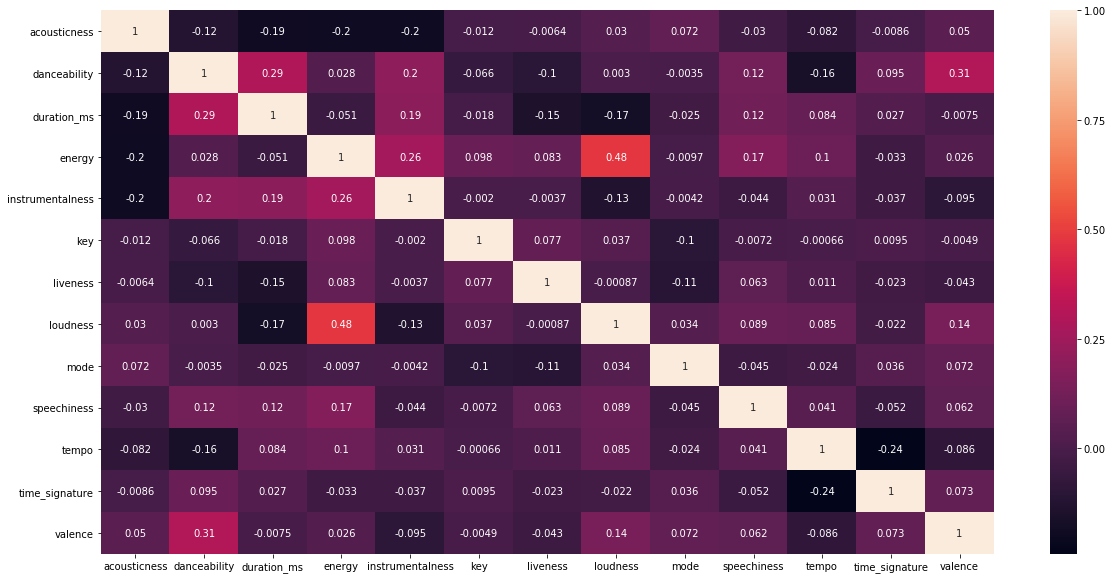

In [15]:
plt.figure(figsize = (20, 10))
sns.heatmap(df_audio_features.corr(), annot =True);

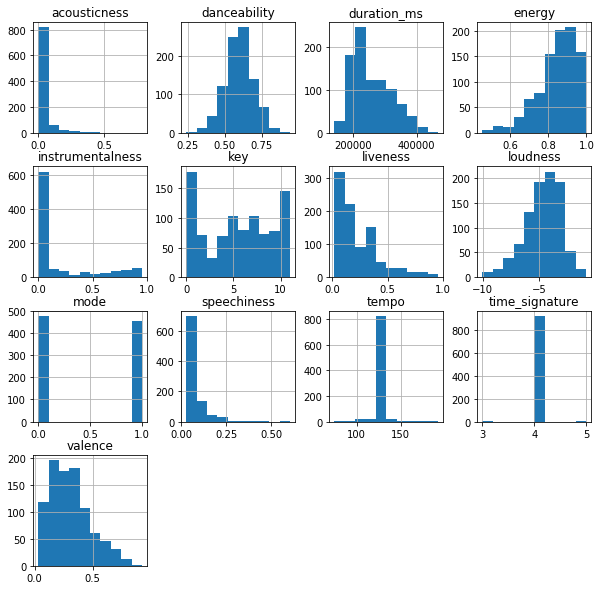

In [16]:
df_audio_features.hist(figsize = (10, 10));

In [17]:
# sns.pairplot(df_audio_features)

<a id='section5'></a>
## Step 5: Merge both dataframes and save


In [18]:
print(df_tracks.shape)
print(df_audio_features.shape)

(929, 8)
(929, 14)


In [36]:
# merge both dataframes
frames = [df_tracks, df_audio_features]
df = pd.concat(frames, axis = 1)

print("Shape of the dataset:", df.shape)
df.tail()

Shape of the dataset: (929, 22)


,album_date,artist_id,artist_name,mp3,track_id,track_length,track_name,track_pop,acousticness,danceability,...,track_id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
924,2018-12-07,0nTbVTXLLbBA4xCtn0cFkv,Myon,https://p.scdn.co/mp3-preview/fa0aa2f934e58db3...,1VZ3EUGMXXPtBWhaDu4bOf,236800,Hearts & Silence - Trivecta Remix,20,0.000465,0.581,...,1VZ3EUGMXXPtBWhaDu4bOf,0.001740,11,0.7060,-3.448,0,0.1650,150.071,4,0.161
925,2018-12-14,6CCTvLyIHqUhY6VQizt150,Jason Ross,https://p.scdn.co/mp3-preview/41bafb99771df635...,0WSJUE47g4OEpaMzL6svD7,263977,Don't Give Up On Me (feat. Dia Frampton),45,0.081600,0.469,...,0WSJUE47g4OEpaMzL6svD7,0.000037,8,0.1180,-5.180,0,0.0728,141.882,4,0.138
926,2018-12-14,2ohlvFf9PBsDELdRstPtlP,Ferry Corsten,https://p.scdn.co/mp3-preview/d258c7b254b9769c...,5pO9ycBL618hEcfCOpRk3l,214153,We're Not Going Home,46,0.001190,0.666,...,5pO9ycBL618hEcfCOpRk3l,0.729000,3,0.1430,-5.104,0,0.0378,130.025,4,0.192
927,2018-12-14,5y3G1B8cpCTaoq0uDgjwzH,Danny Avila,https://p.scdn.co/mp3-preview/fb87efb13c19af96...,4Lb1gZyH6xGzWUNH6R8l0V,178495,End Of The Night - Danny Avila Club Mix,35,0.032900,0.669,...,4Lb1gZyH6xGzWUNH6R8l0V,0.000210,2,0.1910,-3.031,1,0.0798,125.959,4,0.192
928,2019-01-04,2Npo4Cfm48M2uKlvxiXMic,Oliver Smith,https://p.scdn.co/mp3-preview/075f5e4f3864bdfc...,2uVIxV2ZXvIC9JJb0GbWZK,217558,Solina,48,0.000808,0.557,...,2uVIxV2ZXvIC9JJb0GbWZK,0.355000,9,0.0587,-6.146,1,0.0393,128.014,4,0.168


In [37]:
df.isnull().sum()

album_date          0
artist_id           0
artist_name         0
mp3                 0
track_id            0
track_length        0
track_name          0
track_pop           0
acousticness        0
danceability        0
duration_ms         0
energy              0
track_id            0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

In [38]:
# save this final df! and comment out
df.to_csv("./datasets/edm.csv")

In [39]:
# verify the df saved and can be retrieved 
df = pd.read_csv("./datasets/edm.csv", index_col = 'Unnamed: 0')
df.head()

,album_date,artist_id,artist_name,mp3,track_id,track_length,track_name,track_pop,acousticness,danceability,...,track_id.1,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,2016-07-08,7FZKXzbyCoai0fEh65kZKp,Codeko,https://p.scdn.co/mp3-preview/4049f24671437021...,4uXYtzIjJ2vJG8JrfWwkA1,248437,Afterglow,29,0.006010,0.534,...,4uXYtzIjJ2vJG8JrfWwkA1,0.010600,4,0.332,-4.062,1,0.0436,128.014,4,0.501
1,2016-07-08,1rSGNXhhYuWoq9BEz5DZGO,ARTY,https://p.scdn.co/mp3-preview/46d5cea122bf5b21...,6ywNLnm0a3t8Hom8AGKEhb,262501,Follow The Light,31,0.000586,0.373,...,6ywNLnm0a3t8Hom8AGKEhb,0.194000,1,0.101,-7.002,1,0.0583,128.707,4,0.127
2,2016-07-08,6CCTvLyIHqUhY6VQizt150,Jason Ross,https://p.scdn.co/mp3-preview/6151b6e4bf2b5e1a...,0vmMbRON26Z67hH3yzhMQ7,221906,Me Tonight,32,0.010200,0.422,...,0vmMbRON26Z67hH3yzhMQ7,0.039100,0,0.630,-4.973,0,0.0565,128.033,4,0.207
3,2016-06-10,6ioOEWNNGK40H8xrGj6XPW,XYLØ,https://p.scdn.co/mp3-preview/07fce35dd4c81aa7...,1pXeZQxOX64lmoZAle6hQ6,282187,America - Young Bombs Remix,37,0.131000,0.575,...,1pXeZQxOX64lmoZAle6hQ6,0.000299,7,0.354,-4.598,0,0.0546,127.992,4,0.213
4,2016-07-01,3pt2vTpH1eI776oDZT1G2C,Fatum,https://p.scdn.co/mp3-preview/374945b74c9f172e...,5ApQeOVbDaP1pFqIgS3quR,230625,Anybody,14,0.005040,0.585,...,5ApQeOVbDaP1pFqIgS3quR,0.164000,1,0.274,-4.723,1,0.1080,128.011,4,0.645


<a id='section6'></a>
## Step 6: Download edm song clips to local drive

In [40]:
import urllib.request

In [41]:
# I have prepared an empty folder titled "EDM" where each download will be stored under its track_id identifier.
for index, row in df.iterrows():
    url = row['mp3']
    name = row['track_id']
#     print(url)
#     print(row['track_id'])
    urllib.request.urlretrieve(url, './downloads/edm/' + name + '.mp3') 